In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
import multiprocessing as mp
import hashlib
import pickle
import xml.dom.minidom
import traceback
import sys
import zipfile
import urllib.request as urllib23
import os

import configparser
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def _c2bip3(string):
    if sys.version_info[0] > 2:
        return bytes([ord(x) for x in string])
    else:
        return string


class BinaryFile:
    def __init__(self, file):
        self.file = file
        if file == '':
            self.infile = sys.stdin
        elif file.lower().startswith('http://') or file.lower().startswith('https://'):
            try:
                if sys.hexversion >= 0x020601F0:
                    self.infile = urllib23.urlopen(file, timeout=5)
                else:
                    self.infile = urllib23.urlopen(file)
            except urllib23.HTTPError:
                print('Error accessing URL %s' % file)
                print(sys.exc_info()[1])
                sys.exit()
        elif file.lower().endswith('.zip'):
            try:
                self.zipfile = zipfile.ZipFile(file, 'r')
                self.infile = self.zipfile.open(self.zipfile.infolist()[0], 'r', _c2bip3('infected'))
            except:
                print('Error opening file %s' % file)
                print(sys.exc_info()[1])
                sys.exit()
        else:
            try:
                self.infile = open(file, 'rb')
            except:
                print('Error opening file %s' % file)
                print(sys.exc_info()[1])
                sys.exit()
        self.ungetted = []

    def byte(self):
        if len(self.ungetted) != 0:
            return self.ungetted.pop()
        inbyte = self.infile.read(1)
        if not inbyte or inbyte == '':
            self.infile.close()
            return None
        return ord(inbyte)

    def bytes(self, size):
        if size <= len(self.ungetted):
            result = self.ungetted[0:size]
            del self.ungetted[0:size]
            return result
        inbytes = self.infile.read(size - len(self.ungetted))
        if inbytes == '':
            self.infile.close()
        if type(inbytes) == type(''):
            result = self.ungetted + [ord(b) for b in inbytes]
        else:
            result = self.ungetted + [b for b in inbytes]
        self.ungetted = []
        return result

    def unget(self, byte):
        self.ungetted.append(byte)

    def ungets(self, bytes):
        bytes.reverse()
        self.ungetted.extend(bytes)


def _find_pdf_header_relaxed(binary_file_object):
    bytes = binary_file_object.bytes(1024)
    index = ''.join([chr(byte) for byte in bytes]).find('%PDF')
    if index == -1:
        binary_file_object.ungets(bytes)
        return ([], None)
    for end_header in range(index + 4, index + 4 + 10):
        if bytes[end_header] == 10 or bytes[end_header] == 13:
            break
    binary_file_object.ungets(bytes[end_header:])
    return (bytes[0:end_header], ''.join([chr(byte) for byte in bytes[index:end_header]]))


def _hexcode_2_string(char):
    if type(char) == int:
        return '#%02x' % char
    else:
        return char


def _swap_case(char):
    if type(char) == int:
        return ord(chr(char).swapcase())
    else:
        return char.swapcase()


def _hex_2_string(hex_name):
    return ''.join(map(_hexcode_2_string, hex_name))


def _swap_name(word_extract):
    return map(_swap_case, word_extract)


def _update_words(word, word_extract, slash, words, hexcode, names, last_name, inside_stream, entropy, f_out):
    if word != '':
        if slash + word in words:
            words[slash + word][0] += 1
            if hexcode:
                words[slash + word][1] += 1
        elif slash == '/' and names:
            words[slash + word] = [1, 0]
            if hexcode:
                words[slash + word][1] += 1
        if slash == '/':
            last_name = slash + word
        if slash == '':
            if word == 'stream':
                inside_stream = True
            if word == 'endstream':
                if inside_stream == True and entropy != None:
                    for char in 'endstream':
                        entropy.removeInsideStream(ord(char))
                inside_stream = False
        if f_out != None:
            if slash == '/' and '/' + word in (
            '/JS', '/JavaScript', '/AA', '/OpenAction', '/JBIG2Decode', '/RichMedia', '/Launch'):
                word_extractSwapped = _hex_2_string(_swap_name(word_extract))
                f_out.write(_c2bip3(word_extractSwapped))
                print('/%s -> /%s' % (_hex_2_string(word_extract), word_extractSwapped))
            else:
                f_out.write(_c2bip3(_hex_2_string(word_extract)))
    return ('', [], False, last_name, inside_stream)


class CVE_2009_3459:
    def __init__(self):
        self.count = 0

    def check(self, last_name, word):
        if (last_name == '/Colors' and word.isdigit() and int(
                word) > 2 ^ 24):  # decided to alert when the number of colors is expressed with more than 3 bytes
            self.count += 1


def _xml_add_attribute(xmlDoc, name, value=None):
    att = xmlDoc.createAttribute(name)
    xmlDoc.documentElement.setAttributeNode(att)
    if value != None:
        att.nodeValue = value

    return att


def _pdf_2_string(xmlDoc, nozero=False):
    result = 'PDFiD %s %s\n' % (
    xmlDoc.documentElement.getAttribute('Version'), xmlDoc.documentElement.getAttribute('Filename'))
    if xmlDoc.documentElement.getAttribute('ErrorOccured') == 'True':
        return result + '***Error occured***\n%s\n' % xmlDoc.documentElement.getAttribute('ErrorMessage')

    result = f' PDF_Header {xmlDoc.documentElement.getAttribute("Header").split("-")[-1]}\n'
    for node in xmlDoc.documentElement.getElementsByTagName('Keywords')[0].childNodes:
        if not nozero or nozero and int(node.getAttribute('Count')) > 0:
            result += ' %s %d' % (node.getAttribute('Name'), int(node.getAttribute('Count')))

            if int(node.getAttribute('HexcodeCount')) > 0:
                result += '(%d)' % int(node.getAttribute('HexcodeCount'))
            result += '\n'

    if xmlDoc.documentElement.getAttribute('CountEOF') != '':
        result += ' %s %d\n' % ('%%EOF', int(xmlDoc.documentElement.getAttribute('CountEOF')))

    if xmlDoc.documentElement.getAttribute('CountCharsAfterLastEOF') != '':
        result += ' %s %d\n' % (
        'After last %%EOF', int(xmlDoc.documentElement.getAttribute('CountCharsAfterLastEOF')))

    for node in xmlDoc.documentElement.getElementsByTagName('Dates')[0].childNodes:
        result += ' %s %s\n' % (node.getAttribute('Value'), node.getAttribute('Name'))

    if xmlDoc.documentElement.getAttribute('TotalEntropy') != '':
        result += ' Total entropy:           %s (%10s bytes)\n' % (
        xmlDoc.documentElement.getAttribute('TotalEntropy'), xmlDoc.documentElement.getAttribute('TotalCount'))

    if xmlDoc.documentElement.getAttribute('StreamEntropy') != '':
        result += ' Entropy inside streams:  %s (%10s bytes)\n' % (
        xmlDoc.documentElement.getAttribute('StreamEntropy'), xmlDoc.documentElement.getAttribute('StreamCount'))

    if xmlDoc.documentElement.getAttribute('NonStreamEntropy') != '':
        result += ' Entropy outside streams: %s (%10s bytes)\n' % (
        xmlDoc.documentElement.getAttribute('NonStreamEntropy'), xmlDoc.documentElement.getAttribute('NonStreamCount'))

    return result


def _pdf_parse(file, names=True):
    word = ''
    word_extract = []
    hexcode = False
    last_name = ''
    inside_stream = False
    keywords = ['obj',
                'endobj',
                'stream',
                'endstream',
                'xref',
                'trailer',
                'startxref',
                '/Page',
                '/Encrypt',
                '/ObjStm',
                '/JS',
                '/JavaScript',
                '/AA',
                '/OpenAction',
                '/AcroForm',
                '/JBIG2Decode',
                '/RichMedia',
                '/Launch',
                '/EmbeddedFile',
                '/XFA',
                '/Type',
                '/Catalog',
                '/Version',
                '/Pages',
                '/rovers',
                '/abdula',
                '/Kids',
                '/Count',
                '/S',
                '/Filter',
                '/FlateDecode',
                '/Length',
                '/ASCIIHexDecode',
                '/ASCII85Decode',
                '/LZWDecode',
                '/RunLengthDecode',
                '/CCITTFaxDecode',
                '/DCTDecode',
                '/JPXDecode',
                '/Crypt'
                ]
    words = {}
    dates = []

    for keyword in keywords:
        words[keyword] = [0, 0]
    slash = ''
    xmlDoc = xml.dom.minidom.getDOMImplementation().createDocument(None, 'PDFiD', None)
    _xml_add_attribute(xmlDoc, 'Filename', file)
    att_error_occured = _xml_add_attribute(xmlDoc, 'ErrorOccured', 'False')
    att_error_message = _xml_add_attribute(xmlDoc, 'ErrorMessage', '')

    pdf_date = None
    entropy = None
    pdf_eof = None
    cve_2009_3459 = CVE_2009_3459()
    try:
        att_is_pdf = xmlDoc.createAttribute('IsPDF')
        xmlDoc.documentElement.setAttributeNode(att_is_pdf)
        binary_file_object = BinaryFile(file)
        (bytes_header, pdf_header) = _find_pdf_header_relaxed(binary_file_object)
        f_out = None
        if entropy != None:
            for byteHeader in bytes_header:
                entropy.add(byteHeader, inside_stream)

        if pdf_header == None:
            att_is_pdf.nodeValue = 'False'

            return _pdf_2_string(xmlDoc)

        else:
            if pdf_header == None:
                att_is_pdf.nodeValue = 'False'
                pdf_header = ''

            else:
                att_is_pdf.nodeValue = 'True'
            att = xmlDoc.createAttribute('Header')
            att.nodeValue = repr(pdf_header[0:10]).strip("'")
            xmlDoc.documentElement.setAttributeNode(att)
        byte = binary_file_object.byte()
        while byte != None:
            char = chr(byte)
            charUpper = char.upper()
            if charUpper >= 'A' and charUpper <= 'Z' or charUpper >= '0' and charUpper <= '9':
                word += char
                word_extract.append(char)

            elif slash == '/' and char == '#':
                d1 = binary_file_object.byte()
                if d1 != None:
                    d2 = binary_file_object.byte()

                    if d2 != None and (chr(d1) >= '0' and chr(d1) <= '9' or chr(d1).upper() >= 'A' and chr(
                            d1).upper() <= 'F') and (
                            chr(d2) >= '0' and chr(d2) <= '9' or chr(d2).upper() >= 'A' and chr(d2).upper() <= 'F'):
                        word += chr(int(chr(d1) + chr(d2), 16))
                        word_extract.append(int(chr(d1) + chr(d2), 16))
                        hexcode = True

                        if entropy != None:
                            entropy.add(d1, inside_stream)
                            entropy.add(d2, inside_stream)

                        if pdf_eof != None:
                            pdf_eof.parse(d1)
                            pdf_eof.parse(d2)
                    else:
                        binary_file_object.unget(d2)
                        binary_file_object.unget(d1)
                        (word, word_extract, hexcode, last_name, inside_stream) = _update_words(word, word_extract,
                                                                                                slash, words, hexcode,
                                                                                                names, last_name,
                                                                                                inside_stream, entropy,
                                                                                                f_out)
                else:
                    binary_file_object.unget(d1)
                    (word, word_extract, hexcode, last_name, inside_stream) = _update_words(word, word_extract, slash,
                                                                                            words, hexcode, names,
                                                                                            last_name, inside_stream,
                                                                                            entropy, f_out)
            else:
                cve_2009_3459.check(last_name, word)

                (word, word_extract, hexcode, last_name, inside_stream) = _update_words(word, word_extract, slash,
                                                                                        words, hexcode, names,
                                                                                        last_name, inside_stream,
                                                                                        entropy, f_out)
                if char == '/':
                    slash = '/'
                else:
                    slash = ''

            if pdf_date != None and pdf_date.parse(char) != None:
                dates.append([pdf_date.date, last_name])

            if entropy != None:
                entropy.add(byte, inside_stream)

            if pdf_eof != None:
                pdf_eof.parse(char)

            byte = binary_file_object.byte()
        (word, word_extract, hexcode, last_name, inside_stream) = _update_words(word, word_extract, slash, words,
                                                                                hexcode, names, last_name,
                                                                                inside_stream, entropy, f_out)

        # check to see if file ended with %%EOF.  If so, we can reset charsAfterLastEOF and add one to EOF count.  This is never performed in
        # the parse function because it never gets called due to hitting the end of file.
        if byte == None and pdf_eof != None:
            if pdf_eof.token == '%%EOF':
                pdf_eof.cntEOFs += 1
                pdf_eof.cntCharsAfterLastEOF = 0
                pdf_eof.token = ''

    except SystemExit:
        sys.exit()
    except:
        att_error_occured.nodeValue = 'True'
        att_error_message.nodeValue = traceback.format_exc()

    att_entropy_all = xmlDoc.createAttribute('TotalEntropy')
    xmlDoc.documentElement.setAttributeNode(att_entropy_all)
    att_count_all = xmlDoc.createAttribute('TotalCount')
    xmlDoc.documentElement.setAttributeNode(att_count_all)
    att_entropy_stream = xmlDoc.createAttribute('StreamEntropy')
    xmlDoc.documentElement.setAttributeNode(att_entropy_stream)
    att_count_stream = xmlDoc.createAttribute('StreamCount')
    xmlDoc.documentElement.setAttributeNode(att_count_stream)
    att_entropy_non_stream = xmlDoc.createAttribute('NonStreamEntropy')
    xmlDoc.documentElement.setAttributeNode(att_entropy_non_stream)
    att_count_non_stream = xmlDoc.createAttribute('NonStreamCount')
    xmlDoc.documentElement.setAttributeNode(att_count_non_stream)
    if entropy != None:
        (countAll, entropyAll, countStream, entropyStream, countNonStream, entropyNonStream) = entropy.calc()
        att_entropy_all.nodeValue = '%f' % entropyAll
        att_count_all.nodeValue = '%d' % countAll
        if entropyStream == None:
            att_entropy_stream.nodeValue = 'N/A     '

        else:
            att_entropy_stream.nodeValue = '%f' % entropyStream
        att_count_stream.nodeValue = '%d' % countStream
        att_entropy_non_stream.nodeValue = '%f' % entropyNonStream
        att_count_non_stream.nodeValue = '%d' % countNonStream

    else:
        att_entropy_all.nodeValue = ''
        att_count_all.nodeValue = ''
        att_entropy_stream.nodeValue = ''
        att_count_stream.nodeValue = ''
        att_entropy_non_stream.nodeValue = ''
        att_count_non_stream.nodeValue = ''
    att_count_eof = xmlDoc.createAttribute('CountEOF')
    xmlDoc.documentElement.setAttributeNode(att_count_eof)

    att_count_chars_after_last_eof = xmlDoc.createAttribute('CountCharsAfterLastEOF')
    xmlDoc.documentElement.setAttributeNode(att_count_chars_after_last_eof)

    if pdf_eof != None:
        att_count_eof.nodeValue = '%d' % pdf_eof.cntEOFs
        if pdf_eof.cntEOFs > 0:
            att_count_chars_after_last_eof.nodeValue = '%d' % pdf_eof.cntCharsAfterLastEOF
        else:
            att_count_chars_after_last_eof.nodeValue = ''
    else:
        att_count_eof.nodeValue = ''
        att_count_chars_after_last_eof.nodeValue = ''

    ele_keywords = xmlDoc.createElement('Keywords')
    xmlDoc.documentElement.appendChild(ele_keywords)
    for keyword in keywords:
        ele_keyword = xmlDoc.createElement('Keyword')
        ele_keywords.appendChild(ele_keyword)
        att = xmlDoc.createAttribute('Name')
        att.nodeValue = keyword
        ele_keyword.setAttributeNode(att)
        att = xmlDoc.createAttribute('Count')
        att.nodeValue = str(words[keyword][0])
        ele_keyword.setAttributeNode(att)
        att = xmlDoc.createAttribute('HexcodeCount')
        att.nodeValue = str(words[keyword][1])
        ele_keyword.setAttributeNode(att)
    ele_keyword = xmlDoc.createElement('Keyword')
    ele_keywords.appendChild(ele_keyword)
    att = xmlDoc.createAttribute('Name')
    att.nodeValue = '/Colors_2^24'
    ele_keyword.setAttributeNode(att)
    att = xmlDoc.createAttribute('Count')
    att.nodeValue = str(cve_2009_3459.count)
    ele_keyword.setAttributeNode(att)
    att = xmlDoc.createAttribute('HexcodeCount')
    att.nodeValue = str(0)
    ele_keyword.setAttributeNode(att)
    if names:
        keys = sorted(words.keys())
        for word in keys:
            if not word in keywords:
                ele_keyword = xmlDoc.createElement('Keyword')
                ele_keywords.appendChild(ele_keyword)
                att = xmlDoc.createAttribute('Name')
                att.nodeValue = word
                ele_keyword.setAttributeNode(att)
                att = xmlDoc.createAttribute('Count')
                att.nodeValue = str(words[word][0])
                ele_keyword.setAttributeNode(att)
                att = xmlDoc.createAttribute('HexcodeCount')
                att.nodeValue = str(words[word][1])
                ele_keyword.setAttributeNode(att)
    ele_dates = xmlDoc.createElement('Dates')
    xmlDoc.documentElement.appendChild(ele_dates)
    dates.sort(key=lambda x: x[0])
    for date in dates:
        ele_date = xmlDoc.createElement('Date')
        ele_dates.appendChild(ele_date)
        att = xmlDoc.createAttribute('Value')
        att.nodeValue = date[0]
        ele_date.setAttributeNode(att)
        att = xmlDoc.createAttribute('Name')
        att.nodeValue = date[1]
        ele_date.setAttributeNode(att)
    return _pdf_2_string(xmlDoc)


import glob

def get_file_list(PATH):
    ret = []

    for path, dirs, files in os.walk(PATH):
        for file in files:
            md5 = file.split(".")[0]
            if md5 in label:
                ret.append(os.path.join(path, file))

    return ret

In [27]:
import pickle
import random

import numpy as np
import pandas as pd
import os
import warnings
import gc
import time
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import datetime

from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import glob

import lightgbm as lgb



In [28]:
params = {'num_leaves': 64,
         'min_data_in_leaf': 64,
         'objective':'binary',
         'nthread': 1,
         'max_depth': -1,
         'learning_rate': 0.05,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.7 ,
         "bagging_seed": 11,
         "metric": ['auc','binary_logloss'],
         "lambda_l1": 0.1,
         "random_state": 24,
         "verbosity": -1}

In [39]:
label = dict()
with open(r"D:\capstone\pdf\data\pdf_new_label.csv", "r") as f:
    next(iter(f))
    for line in f.readlines():
        md5, label_ = line.strip().split(",")

        label[md5] = int(label_)



# 데이터, 라벨 로드

In [40]:
FEATURE_PATH = r"D:\capstone\pdf\data\fh_new_2\fh_virussign\11"
FEATURE_PATH2 = r"D:\capstone\pdf\data\fh_new_2\fh_virussign\12"
# FEATURE_PATH3 = r"D:\capstone\pdf\data\fh_new_2\fh_virussign\01"

mal_path = []
ben_path = []
feature_list = glob.glob(os.path.join(FEATURE_PATH, "*.pkl"))
feature_list += glob.glob(os.path.join(FEATURE_PATH2, "*.pkl"))
# feature_list += glob.glob(os.path.join(FEATURE_PATH3, "*.pkl"))

for path in tqdm(feature_list):
    md5 = os.path.basename(path).split(".")[0]
#     if md5 in sample:
    if md5 in label:
        if label[md5] == 1:
            mal_path.append(path)
        else:
            ben_path.append(path)

print(len(mal_path), len(ben_path))



74875 71367


In [41]:
trn_path = mal_path + ben_path

# random.shuffle(trn_path)
trn_data = []
target = []
trn_set = set()
for path in tqdm(trn_path):
    md5 = os.path.basename(path).split(".")[0]

    if md5 in label:
        try:
            with open(path, "rb") as f:
                feature = pickle.load(f)
            trn_data.append(feature)
            target.append(label[md5])
            trn_set.add(md5)
        except:
            continue



# 학습 (XGBoost)

In [8]:
import xgboost as xgb

param = {'eta': 1, "lambda":0.7, 'objective': 'binary:logistic', "metric":"auc", "silent":True}

dtrain = xgb.DMatrix(trn_data, label=target)

xgb_clf = xgb.train(param, dtrain, num_boost_round=100, evals=[(dtrain, "train")], early_stopping_rounds=5, verbose_eval=5)

[0]	train-error:0.020487
Will train until train-error hasn't improved in 5 rounds.
[5]	train-error:0.010518
[10]	train-error:0.009069
[15]	train-error:0.00748
[20]	train-error:0.007584
[25]	train-error:0.005144
[30]	train-error:0.004609
[35]	train-error:0.003736
[40]	train-error:0.003506
[45]	train-error:0.003331
[50]	train-error:0.003241
[55]	train-error:0.002727
[60]	train-error:0.002498
[65]	train-error:0.002372
[70]	train-error:0.002156
[75]	train-error:0.001944
[80]	train-error:0.001872
[85]	train-error:0.001719
[90]	train-error:0.001593
[95]	train-error:0.001422
[99]	train-error:0.001395


In [9]:
# with open("dreamav_xgb.model", "wb") as f:
#     pickle.dump(xgb_clf, f)
# # xgb_clf.dump_model("dreamav_xgb.model")

# 학습 (LightGBM)

In [42]:
N_FOLDS = 10

trn = lgb.Dataset(trn_data, label=target)

bst = lgb.train(params,
                trn,
                num_boost_round=5000,
                valid_sets=trn,
                verbose_eval=100,
                early_stopping_rounds=200
                )
#
# cv_results = lgb.cv(params, trn, nfold=N_FOLDS, verbose_eval=20, early_stopping_rounds=200)

# print('Best num_boost_round:', len(cv_results['auc-mean']))
# print('Best CV score:', cv_results['auc-mean'][-1])

 

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.999903	training's binary_logloss: 0.0134019
[200]	training's auc: 0.999999	training's binary_logloss: 0.00314905
[300]	training's auc: 1	training's binary_logloss: 0.00113717
[400]	training's auc: 1	training's binary_logloss: 0.00051463
[500]	training's auc: 1	training's binary_logloss: 0.000286609
Early stopping, best iteration is:
[344]	training's auc: 1	training's binary_logloss: 0.00078206


In [11]:
# bst.save_model("dreamav_lgb.model", num_iteration=bst.best_iteration)

# bst = bst.

# 검증

In [43]:
test_label = dict()
# with open(r"D:\capstone\pdf\data\virustotal_sample_label.csv", "r") as f:
#     next(iter(f))
    
#     for line in f.readlines():
#         md5, label = line.strip().split(",")
        
#         test_label[md5] = int(label)
with open(r"D:\capstone\pdf\data\pdf_new_label.csv", "r") as f:
    next(iter(f))
    
    for line in f.readlines():
        md5, label = line.strip().split(",")
        
        test_label[md5] = int(label)
        

In [44]:
test = []
test_md5 = []

# test_feature = glob.glob(r"D:\capstone\pdf\data\fh_new_1\fh_virusign_virushare\*")

# BASE = r""
# test_feature += glob.glob(r"D:\capstone\pdf\data\fh_new_1\fh_self\*")

test_feature = glob.glob(r"D:\capstone\pdf\data\clam_sample_fv\*.pkl")
# test_feature = glob.glob(r"D:\capstone\pdf\data\fh_new_2\fh_virussign\01\*")


y_test = []
# mal, ben, mal_md5, ben_md5 = [], [], [], []
for path in tqdm(test_feature):
    md5 = os.path.basename(path).split(".")[0]

    if md5 in test_label and md5 not in trn_set:
        with open(path, "rb") as f:
            feature = pickle.load(f)
        try:
            test.append(feature)
            test_md5.append(md5)
            y_test.append(test_label[md5])
        except:
            continue



In [33]:
import pickle

bst = lgb.Booster(model_file=r"D:\capstone\dreamav_lgb.model")

In [45]:
predict = bst.predict(test, num_iteration=bst.best_iteration)
# xgb_predict = xgb_clf.predict(xgb.DMatrix(test))

In [46]:
len(test)

500

In [16]:
# test_feature_md5 = [os.path.basename(x).split(".")[0] for x in test_feature]

In [50]:
acc = 0
tp = 0
tn = 0
fp = 0
fn = 0

mal = 0
ben = 0

predict = [1 if x >= 0.5 else 0 for x in predict]
xgb_predict = [1 if x >= 0.5 else 0 for x in xgb_predict]

wrong_files = []

for i in range(len(predict)):
    if predict[i] == test_label[test_md5[i]]:
        acc += 1
        if predict[i] == 1:
            tp += 1
        else:
            tn += 1
    else:
        wrong_files.append(test_md5[i])
        if predict[i] == 1:
            fp += 1
        else:
            fn += 1

    if test_label[test_md5[i]] == 1:
        mal += 1
        
    else:
        ben += 1


        
print(mal, ben, acc / len(predict) * 100, tp, tn, fp, fn)

print("LightGBM Accuracy is", accuracy_score(y_test, predict))
print("LightGBM F1-Score is ", f1_score(y_test, predict))
# print("LightGBM Precision is ", precision_score(y_test, predict))
# print("LightGBM Recall is ", recall_score(y_test, predict))
# print("XGBoost Accuracy is", accuracy_score(y_test, xgb_predict))
# print("XGBoost F1-Score is ", f1_score(y_test, xgb_predict))


500 0 91.60000000000001 458 0 0 42
LightGBM Accuracy is 0.916
LightGBM F1-Score is  0.9561586638830899


plot confusion matrix start: 

C:\Users\user\Anaconda_3.6.5\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix


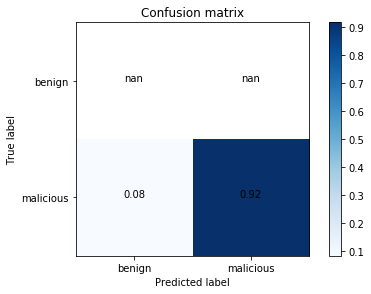

--plot confusion matrix finish--


In [57]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(y_true, y_pred):
    print('plot confusion matrix start: ', end='')

    # compute confusion matrix
    cnf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    # configuration
    np.set_printoptions(precision=2)

#     labels = [""]
    labels = ['benign', 'malicious']
    norm_flag = True
    plot_title = 'Confusion matrix'
    cmap = plt.cm.Blues

    if norm_flag:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # plotting start
    plt.figure()
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(plot_title)

    plt.colorbar()
    tick_marks = np.arange(len(labels))
    # plt.xticks(tick_marks, labels, rotation=90)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)

    # information about each block's value
    fmt = '.2f' if norm_flag else 'd'
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    ## insert legend information
    # import matplotlib.patches as mpatches
    # patches = [mpatches.Patch(color='white', label='G{num} = {group}'.format(num=i+1, group=labels[i])) for i in range(len(labels))]
    # plt.legend(handles=patches, bbox_to_anchor=(-0.60, 1), loc=2, borderaxespad=0.)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    print('--plot confusion matrix finish--')
    pass

plot_confusion_matrix(y_test, predict)

In [18]:
# import json

# BASE_PATH = r"D:\capstone\pdf\data\virustotal_pdf\report"

# wrong_file_type = dict()
# for md5 in wrong_files:
#     with open(os.path.join(BASE_PATH, md5 + ".json"), "r") as f:
#         report = json.load(f)
    
#     detect = report["scans"]["Kaspersky"]["result"]
#     wrong_file_type[detect] = wrong_file_type.get(detect, 0) + 1
    

In [19]:
# sorted_wrong_file_type = sorted(wrong_file_type.items(), key=lambda x: x[1], reverse=True)
# for k, v in sorted_wrong_file_type:
#     print(k, v)

In [20]:
# file_type = dict()
# for md5 in os.listdir(BASE_PATH):
#     with open(os.path.join(BASE_PATH, md5), "r") as f:
#         report = json.load(f)
#     try:
#         detect = report["scans"]["Kaspersky"]["result"]
#         file_type[detect] = file_type.get(detect, 0) + 1
#     except:
#         pass

In [21]:
# sorted_file_type = sorted(file_type.items(), key=lambda x: x[1], reverse=True)
# for k, v in sorted_file_type:
#     print(k, v)

In [24]:
def compare_model(x_train, train_label, y_train, y_test):
    models = []
#     models.append(("LR", LogisticRegression()))
#     models.append(("DT", DecisionTreeClassifier()))
    models.append(("SVM", SVC()))
#     models.append(("NB", GaussianNB()))
#     models.append(("KNN",KNeighborsClassifier()))
#     models.append(("RF", RandomForestClassifier()))

    for name, model in models:
        start = time.time()
        model.fit(x_train, train_label)
        print("FIT", time.time() - start)
        y_pred = model.predict(y_train)
        print(name, "'s Accuracy is ", accuracy_score(y_test, y_pred))
        print(name, "'s F1-Score is ", f1_score(y_test, y_pred))
#         print(name, "'s Precision is ", precision_score(y_test, y_pred,average='macro'))
#         print(name, "'s Recall is ", recall_score(y_test, y_pred,average='macro'))

        
print("START")
compare_model(trn_data, target, test, y_test)

START
FIT 18392.253772497177
SVM 's Accuracy is  0.8950141110065851
SVM 's F1-Score is  0.9445988880063543


### fh_new_1 :  FH 512 (virussign 11, 12 >> 1)

26619 49326 89.4594772532754 25447 42493 6833 1172  
LightGBM Accuracy is 0.894594772532754  
LightGBM Precision is  0.8807401113240935  
LightGBM Recall is  0.9087219750182419  
LightGBM F1-Score is  0.8890028869229449  

### fh_new_2 : Version + Fix(43) + FH(128) (virussign 11, 12 >> 1)
26619 49326 89.6490881559023 24623 43461 5865 1996  
LightGBM Accuracy is 0.896490881559023  
LightGBM F1-Score is  0.8897046543140308  
FIT 25.278382539749146  
LR 's Accuracy is  0.8993087102508395  
LR 's F1-Score is  0.8807941889489606  
FIT 11.068392515182495  
DT 's Accuracy is  0.8898018302719073  
DT 's F1-Score is  0.8827957477142934  
FIT 2.3826260566711426  
NB 's Accuracy is  0.7406412535387451  
NB 's F1-Score is  0.739810233943766  
FIT 6.218365907669067  
KNN 's Accuracy is  0.8854829152676279  
KNN 's F1-Score is  0.8784368614389162  
FIT 5.6818013191223145  
RF 's Accuracy is  0.9569556916189348  
RF 's F1-Score is  0.9520542899874413  

### fh_old : Fix(43) (virustotal) 13880 16120
9608 0 81.89009159034138 7868 0 0 1740  
LightGBM Accuracy is 0.8189009159034139  
XGBoost Accuracy is 0.7979808492922564  

### fh_1 : Version + FH(512) (virustotal) 13880 16120  
10630 0 90.88428974600188 9661 0 0 969  
LightGBM Accuracy is 0.9088428974600188  
XGBoost Accuracy is 0.9281279397930385  

### fh_new_2 : Version + Fix(43) + FH(128) (virustotal)13880 16120
10630 0 88.49482596425212 9407 0 0 1223  
LightGBM Accuracy is 0.8849482596425212  
XGBoost Accuracy is 0.9261523988711194  

### fh_new_2 : Version + Fix(43) + FH(128) (virustotal) 220,000
10630 0 95.48447789275635 10150 0 0 480  
LightGBM Accuracy is 0.9548447789275635  
LightGBM F1-Score is  0.48845043310875846  
XGBoost Accuracy is 0.9517403574788335  
XGBoost F1-Score is  0.4876367667614595  
LR 's Accuracy is  9.407337723424271e-05  
LR 's F1-Score is  0.00018812905653278148  
SVM 's Accuracy is  0.8950141110065851  
SVM 's F1-Score is  0.9445988880063543  
DT 's Accuracy is  0.9610536218250235  
DT 's F1-Score is  0.9801400748345006  
NB 's Accuracy is  0.8129821260583255  
NB 's F1-Score is  0.8968451639684517  
KNN 's Accuracy is  0.8611476952022578  
KNN 's F1-Score is  0.9253942579862514  
RF 's Accuracy is  0.9170272812793979  
RF 's F1-Score is  0.9567180292472274  



101494 120693

In [23]:
# with open("./dreamav_xgb.model", "rb") as f:
#     clf = pickle.load(f)
